In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import simtk.openmm as mm
from torsionfit import TorsionScanSet as ScanSet
import torsionfit.TorsionFitModel as Model
from torsionfit import sqlite_plus
from pymc import MCMC
from parmed.charmm import CharmmParameterSet
from torsionfit import plots
from matplotlib.backends.backend_pdf import PdfPages

/Users/chayastern/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
param_to_opt=[('CG331', 'CG321', 'CG321', 'CG331')]
param = CharmmParameterSet('../data/charmm_ff/top_all36_cgenff.rtf', '../data/charmm_ff/par_all36_cgenff.prm')
structure = 'structure/butane.psf'
scan = 'MP2_torsion_scan/'
# Print initial guess
print param.dihedral_types[param_to_opt[0]]

# Create a butane scan with torsions on (to compare for difference potential)
butane_scan = ScanSet.parse_psi4_out(scan, structure)
butane_scan.compute_energy(param)
optimized = butane_scan.remove_nonoptimized()
optimized.compute_energy(param)

# Turn off torsion
param.dihedral_types[('CG331', 'CG321', 'CG321', 'CG331')][1].phi_k=0
param.dihedral_types[('CG331', 'CG321', 'CG321', 'CG331')][0].phi_k=0

# Create butane scan with torsions off
optimized_0 = butane_scan.remove_nonoptimized()
optimized_0.compute_energy(param)

<DihedralTypes [<DihedralType; phi_k=0.038, per=2, phase=0.000,  scee=1.000, scnb=1.000>, <DihedralType; phi_k=0.032, per=6, phase=180.000,  scee=1.000, scnb=1.000>]>
[Psi /Users/chayastern/src/ChayaSt/Torsions/examples/butane/MP2_torsion_scan/0/butane_0.out2 WARNING] In logfileparser.py, line 467, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/chayastern/src/ChayaSt/Torsions/examples/butane/MP2_torsion_scan/10/butane_10.out2 WARNING] In logfileparser.py, line 467, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/chayastern/src/ChayaSt/Torsions/examples/butane/MP2_torsion_scan/20/butane_20.out2 WARNING] In logfileparser.py, line 467, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/chayastern/src/ChayaSt/Torsions

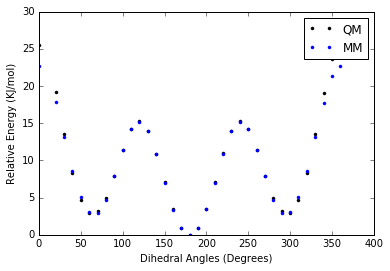

In [5]:
plt.plot(optimized.steps, optimized.qm_energy, 'k.', label='QM')
plt.plot(optimized.steps, optimized.mm_energy, '.', label='MM')
plt.xlabel('Dihedral Angles (Degrees)')
plt.ylabel('Relative Energy (KJ/mol)')
plt.legend()

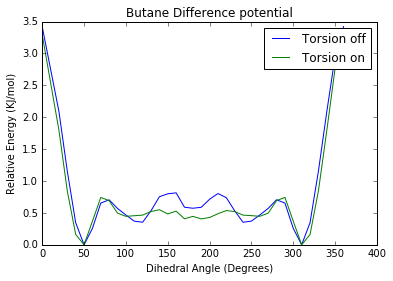

In [6]:
plt.plot(optimized_0.steps, optimized_0.delta_energy-min(optimized_0.delta_energy), label='Torsion off')
plt.plot(optimized.steps, optimized.delta_energy-min(optimized.delta_energy), label='Torsion on')
plt.legend()
plt.xlabel('Dihedral Angle (Degrees)')
plt.ylabel('Relative Energy (KJ/mol)')
plt.title('Butane Difference potential')

In [7]:
platform = mm.Platform.getPlatformByName('Reference')
model = Model.TorsionFitModelEliminatePhase(param, optimized, platform=platform, 
                                            param_to_opt=param_to_opt)
sampler = MCMC(model.pymc_parameters, db=sqlite_plus, dbname='butane_n.database', verbose=5)

In [8]:
sampler.sample(100000)

Assigning step method Metropolis to stochastic BUTA1_offset
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_6_K
Assigning step method DiscreteMetropolis to stochastic CG331_CG321_CG321_CG331_multiplicity_bitstring
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_1_K
Assigning step method Metropolis to stochastic log_sigma
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_2_K
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_3_K
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_4_K
 [-----------------100%-----------------] 100000 of 100000 complete in 7141.3 sec

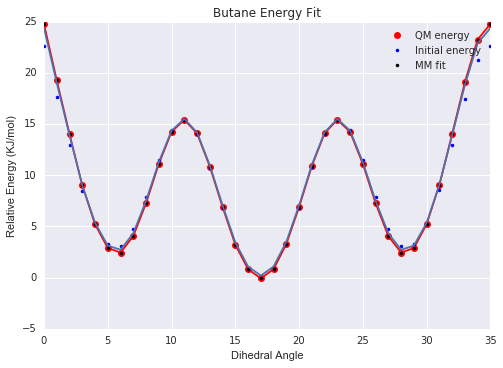

In [39]:
import seaborn
plt.plot(optimized.mm_energy, 'ro', label='QM energy')
plt.plot(optimized.mm_energy, color='r')
plt.plot(sampler.trace('mm_energy')[0], 'b.', label='Initial energy')
plt.plot(sampler.trace('mm_energy')[-1], 'k.', label='MM fit')

seaborn.tsplot(sampler.trace('mm_energy')[:])
plt.legend()
plt.xlabel('Dihedral Angle')
plt.ylabel('Relative Energy (KJ/mol)')
plt.title('Butane Energy Fit')
plt.savefig('sample_n/Energy_fit_n.pdf')

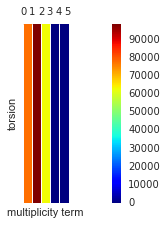

In [13]:
plots.marg_mult(model, sampler, 100000)

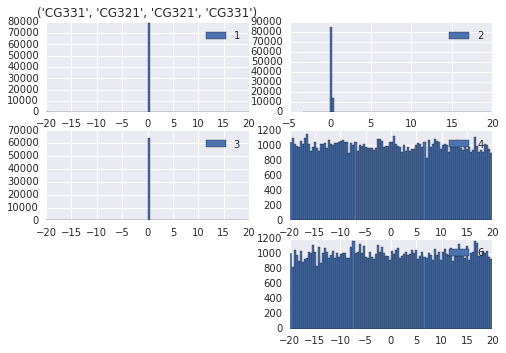

In [14]:
db = sqlite_plus.load('butane_n_init_0.database')
multiplicities = ['1', '2', '3', '4', '6']
with PdfPages('param_hist.pdf') as pdf:
    for torsion in param_to_opt:
        torsion_name = torsion[0] + '_' + torsion[1] + '_' + torsion[2] + '_' + torsion[3]
        for n, m in enumerate(multiplicities):
            if n==1:
                plt.title(torsion)
            plt.subplot(3, 2, int(m))
            k = torsion_name + '_' + m + '_K'
            plt.hist(getattr(db, k)[:], bins=100, label=m)
            plt.legend()
        pdf.savefig()
        plt.show()
        plt.close()

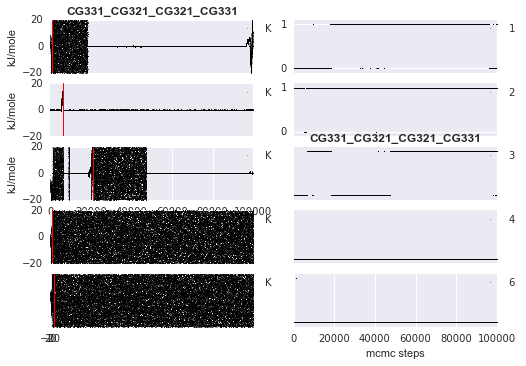

In [18]:
import seaborn
db = sqlite_plus.load('butane_n.database')
plots.trace_no_phase('CG331_CG321_CG321_CG331', db, markersize=1.0, filename='trace_n_init_0.pdf')

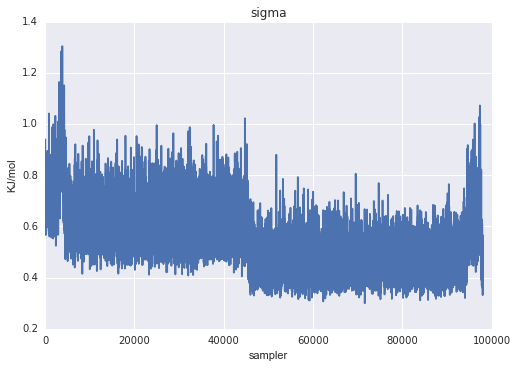

In [19]:
import numpy as np
plt.plot(np.exp(sampler.log_sigma.trace[2000:]))
plt.title('sigma')
plt.xlabel('sampler')
plt.ylabel('KJ/mol')
plt.savefig('sigma_n.png')

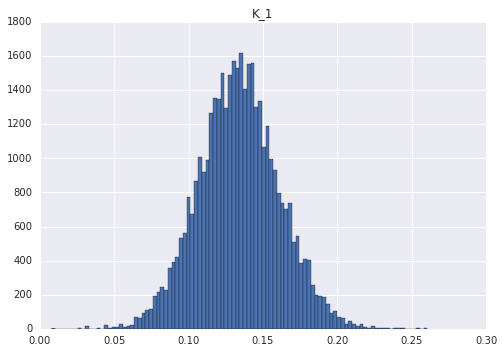

In [29]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_1_K')[50000:90000], bins=100)
plt.title('K_1')

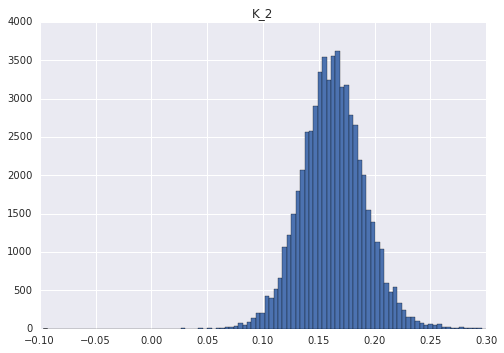

In [30]:
plt.hist(db.trace('CG331_CG321_CG321_CG331_2_K')[40000:], bins=100)
plt.title('K_2')

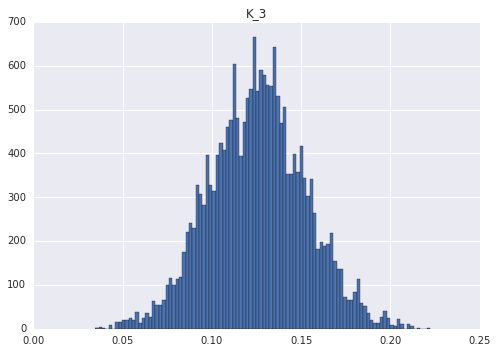

In [44]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_3_K')[60000:80000], bins=100)
plt.title('K_3')

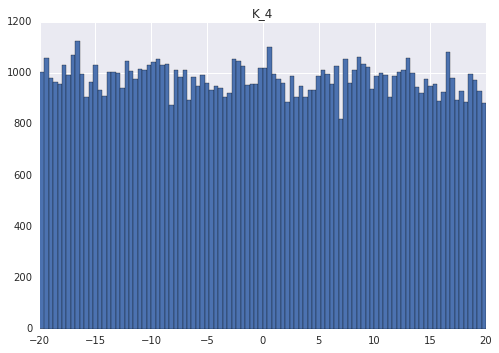

In [33]:
plt.hist(db.trace('CG331_CG321_CG321_CG331_4_K')[2000:], bins=100)
plt.title('K_4')

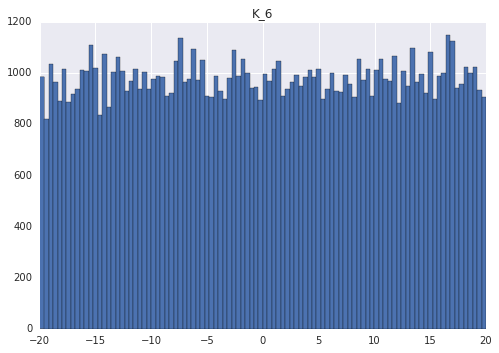

In [34]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_6_K')[2000:], bins=100)
plt.title('K_6')

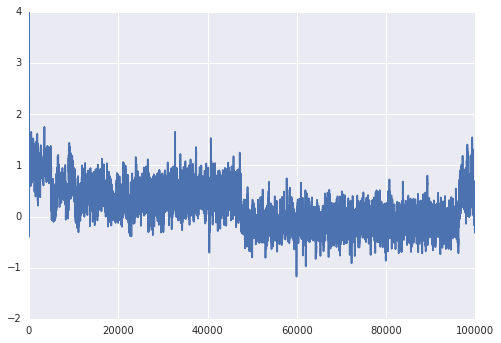

In [25]:
plt.plot(sampler.BUTA1_offset.trace[:])

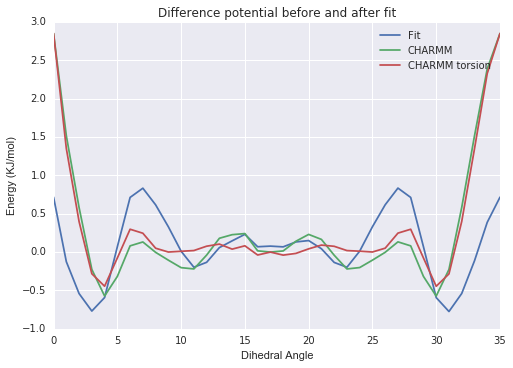

In [43]:
# Reload param and reparameterize
# reparameterize 
param_new = CharmmParameterSet('../data/charmm_ff/top_all36_cgenff.rtf', '../data/charmm_ff/par_all36_cgenff.prm')
# Turn off torsion
#param_new.dihedral_types[('CG331', 'CG321', 'CG321', 'CG331')][1].phi_k=0
#param_new.dihedral_types[('CG331', 'CG321', 'CG321', 'CG331')][0].phi_k=0

torsion = optimized_0.remove_nonoptimized()
torsion.compute_energy(param_new)
plt.plot(optimized.delta_energy, label='Fit')
plt.plot(optimized_0.delta_energy, label='CHARMM')
plt.plot(torsion.delta_energy, label='CHARMM torsion')
plt.title('Difference potential (QM-MM)')
plt.xlabel('Dihedral Angle')
plt.ylabel('Energy (KJ/mol)')
plt.legend()
plt.savefig('sample_n/diff_pot.png')
plt.savefig('sample_n/diff_pot.pdf')

#plt.plot(optimized.delta_energy, label='After fit')
#plt.plot(optimized_0.delta_energy, label='Diff')
plt.legend()
plt.title('Difference potential before and after fit')
plt.savefig('sample_n/diff_pot_fit.pdf')
plt.savefig('sample_n/diff_pot_fit.png')